In [1]:
import os
import time
import glob
import gdown
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import csv
import cv2
import itertools
import matplotlib.pyplot as plt
import skimage.feature as feature
import xlwings as xw
import torchvision.transforms as transforms

#libraries for yolo
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, FuncFormatter, )

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def download_weights():
    model_file=[
        'yolo_face_sthanhng.weights',
        'yolo_face_sthanhng.cfg'
    ]
    
    gdrive_url=[
        'https://drive.google.com/uc?id=1utquM5TAnfIa1Aq0X9fCvrllHiTWazdD',
        'https://drive.google.com/uc?id=1CPUZlYL5ik4d9y6oCyzi0930KgzawI6V'
    ]
    
    cwd=os.getcwd() 
    if 'weights' in os.listdir(cwd):
        for i in range(len(model_file)):
            if model_file[i] in os.listdir(os.path.join(cwd, 'weights')):
                print(model_file[i] + ':: status : file already exists')
            else:
                gdown.download(gdrive_url[i],os.path.join(cwd, 'weights', model_file[i]), quiet=False)
    else:
        os.makedirs(os.path.join(cwd,'weights'))
        for i in range(len(model_file)):
            gdown.download(gdrive_url[i], os.path.join(cwd, 'weights', model_file[i]), quiet=False)  

In [3]:
# download the necessary weights for YOLO-Face
download_weights()

yolo_face_sthanhng.weights:: status : file already exists
yolo_face_sthanhng.cfg:: status : file already exists


## YOLOFace with FGSM

In [4]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

epsilons = [0, .05]
use_cuda=True

CUDA Available:  False


In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, x1, y1, x2, y2):
    # Collect the element-wise sign of the data gradient
    image = image
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image
    perturbed_image[:, :, y1:y2, x1:x2] = perturbed_image[:, :, y1:y2, x1:x2] + epsilon * sign_data_grad[:, :, y1:y2, x1:x2] # apply it only to the face region
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp

# From https://medium.com/mlearning-ai/how-to-plot-color-channels-histogram-of-an-image-in-python-using-opencv-40022032e127
# Extracts image's color channel
def extract_color_channel(path, face_index, image):
    # BGR Image Color Conversion
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

#     # RGB Image Histogram
#     red_hist = cv2.calcHist([rgb], [0], None, [256], [0, 256])
#     green_hist = cv2.calcHist([rgb], [1], None, [256], [0, 256])
#     blue_hist = cv2.calcHist([rgb], [2], None, [256], [0, 256])

#     # HSV Image Histogram
#     hue_hist_HSV = cv2.calcHist([hsv], [0], None, [256], [0, 256])
#     saturation_hist_HSV = cv2.calcHist([hsv], [1], None, [256], [0, 256])
#     value_hist = cv2.calcHist([hsv], [2], None, [256], [0, 256])

#     # HLS Image Histogram
#     hue_hist_HLS = cv2.calcHist([hls], [0], None, [256], [0, 256])
#     lightness_hist_HLS = cv2.calcHist([hls], [1], None, [256], [0, 256])
#     saturation_hist_HLS = cv2.calcHist([hls], [2], None, [256], [0, 256])

#     # LAB Image Histogram
#     lightness_hist_LAB = cv2.calcHist([lab], [0], None, [256], [0, 256])
#     a_hist_LAB = cv2.calcHist([lab], [1], None, [256], [0, 256])
#     b_hist_LAB = cv2.calcHist([lab], [2], None, [256], [0, 256])

#     # YCrCb Image Histogram
#     y_hist = cv2.calcHist([ycrcb], [0], None, [256], [0, 256])
#     cr_hist = cv2.calcHist([ycrcb], [1], None, [256], [0, 256])
#     cb_hist = cv2.calcHist([ycrcb], [2], None, [256], [0, 256])

#     # RGB Image Plot
#     plt.subplot(4, 1, 1)
#     plt.imshow(rgb)
#     plt.title('RGB Image')
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(4, 1, 2)
#     plt.plot(red_hist, color='r')
#     plt.xlim([0, 256])
#     plt.ylim([0, 500])
#     plt.title('Red Histogram')

#     plt.subplot(4, 1, 3)
#     plt.plot(green_hist, color='g')
#     plt.xlim([0, 256])
#     plt.ylim([0, 500])
#     plt.title('Green Histogram')

#     plt.subplot(4, 1, 4)
#     plt.plot(blue_hist, color='b')
#     plt.xlim([0, 256])
#     plt.ylim([0, 500])
#     plt.title('Blue Histogram')

#     plt.tight_layout()
#     #plt.show()

    r, g, b = cv2.split(rgb)
    
    r_hist = cv2.calcHist([r], [0], None, [26], [0, 256])
    r_hist = r_hist.ravel()
    r_hist = r_hist.astype('float')
    r_hist /= r_hist.sum()
    
    g_hist = cv2.calcHist([g], [0], None, [26], [0, 256])
    g_hist = g_hist.ravel()
    g_hist = g_hist.astype('float')
    g_hist /= g_hist.sum()
    
    b_hist = cv2.calcHist([b], [0], None, [26], [0, 256])
    b_hist = b_hist.ravel()
    b_hist = b_hist.astype('float')
    b_hist /= b_hist.sum()

#     # HSV Image Plot
#     plt.subplot(4, 1, 1)
#     #plt.imshow(hsv)
#     plt.title('HSV Image')
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(4, 1, 2)
#     plt.plot(hue_hist_HSV, color='c')
#     plt.xlim([0, 256])
#     plt.ylim([0, 2500])
#     plt.title('Hue Histogram')

#     plt.subplot(4, 1, 3)
#     plt.plot(saturation_hist_HSV, color='m')
#     plt.xlim([0, 256])
#     plt.ylim([0, 1000])
#     plt.title('Saturation Histogram')

#     plt.subplot(4, 1, 4)
#     plt.plot(value_hist, color='y')
#     plt.xlim([0, 256])
#     plt.ylim([0, 1000])
#     plt.title('Value Histogram')

#     plt.tight_layout()
#     plt.show()
    
    h, s, v = cv2.split(hsv)
    
    h_hist_HSV = cv2.calcHist([h], [0], None, [18], [0, 181])
    h_hist_HSV = h_hist_HSV.ravel()
    h_hist_HSV = h_hist_HSV.astype('float')
    h_hist_HSV /= h_hist_HSV.sum()
    
    s_hist_HSV = cv2.calcHist([s], [0], None, [26], [0, 256])
    s_hist_HSV = s_hist_HSV.ravel()
    s_hist_HSV = s_hist_HSV.astype('float')
    s_hist_HSV /= s_hist_HSV.sum()
    
    v_hist_HSV = cv2.calcHist([v], [0], None, [26], [0, 256])
    v_hist_HSV = v_hist_HSV.ravel()
    v_hist_HSV = v_hist_HSV.astype('float')
    v_hist_HSV /= v_hist_HSV.sum()
    
#     # HLS Image Plot
#     plt.subplot(4, 1, 1)
#     plt.imshow(hls)
#     plt.title('HLS Image')
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(4, 1, 2)
#     plt.plot(hue_hist_HLS, color='r')
#     plt.xlim([0, 256])
#     plt.ylim([0, 2500])
#     plt.title('Hue Histogram')

#     plt.subplot(4, 1, 3)
#     plt.plot(lightness_hist_HLS, color='g')
#     plt.xlim([0, 256])
#     plt.ylim([0, 1000])
#     plt.title('Lightness Histogram')

#     plt.subplot(4, 1, 4)
#     plt.plot(saturation_hist_HLS, color='b')
#     plt.xlim([0, 256])
#     plt.ylim([0, 1000])
#     plt.title('Saturation Histogram')

#     plt.tight_layout()
#     plt.show()

    h, l, s = cv2.split(hls)
    
    h_hist_HSL = cv2.calcHist([h], [0], None, [18], [0, 181])
    h_hist_HSL = h_hist_HSL.ravel()
    h_hist_HSL = h_hist_HSL.astype('float')
    h_hist_HSL /= h_hist_HSL.sum()
    
    l_hist_HSL = cv2.calcHist([l], [0], None, [26], [0, 256])
    l_hist_HSL = l_hist_HSL.ravel()
    l_hist_HSL = l_hist_HSL.astype('float')
    l_hist_HSL /= l_hist_HSL.sum()
    
    s_hist_HSL = cv2.calcHist([s], [0], None, [26], [0, 256])
    s_hist_HSL = s_hist_HSL.ravel()
    s_hist_HSL = s_hist_HSL.astype('float')
    s_hist_HSL /= s_hist_HSL.sum()
    
#     # LAB Image Plot
#     plt.subplot(4, 1, 1)
#     plt.imshow(lab)
#     plt.title('LAB Image')
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(4, 1, 2)
#     plt.plot(lightness_hist_LAB, color='c')
#     plt.xlim([0, 256])
#     plt.ylim([0, 1000])
#     plt.title('Lightness Histogram')

#     plt.subplot(4, 1, 3)
#     plt.plot(a_hist_LAB, color='m')
#     plt.xlim([0, 256])
#     plt.ylim([0, 20000])
#     plt.title('A Histogram')

#     plt.subplot(4, 1, 4)
#     plt.plot(b_hist_LAB, color='y')
#     plt.xlim([0, 256])
#     plt.ylim([0, 20000])
#     plt.title('B Histogram')

#     plt.tight_layout()
#     plt.show()
    
    l, a, b = cv2.split(lab)
    
    l_hist_LAB = cv2.calcHist([l], [0], None, [26], [0, 256])
    l_hist_LAB = l_hist_LAB.ravel()
    l_hist_LAB = l_hist_LAB.astype('float')
    l_hist_LAB /= l_hist_LAB.sum()
    
    a_hist_LAB = cv2.calcHist([a], [0], None, [26], [0, 256])
    a_hist_LAB = a_hist_LAB.ravel()
    a_hist_LAB = a_hist_LAB.astype('float')
    a_hist_LAB /= a_hist_LAB.sum()
    
    b_hist_LAB = cv2.calcHist([b], [0], None, [26], [0, 256])
    b_hist_LAB = b_hist_LAB.ravel()
    b_hist_LAB = b_hist_LAB.astype('float')
    b_hist_LAB /= b_hist_LAB.sum()
    
#     # YCrCb Image Plot
#     plt.subplot(4, 1, 1)
#     plt.imshow(ycrcb)
#     plt.title('YCrCb Image')
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(4, 1, 2)
#     plt.plot(y_hist, color='r')
#     plt.xlim([0, 256])
#     plt.ylim([0, 1000])
#     plt.title('Y Histogram')

#     plt.subplot(4, 1, 3)
#     plt.plot(cr_hist, color='g')
#     plt.xlim([0, 256])
#     plt.ylim([0, 20000])
#     plt.title('Cr Histogram')

#     plt.subplot(4, 1, 4)
#     plt.plot(cb_hist, color='b')
#     plt.xlim([0, 256])
#     plt.ylim([0, 20000])
#     plt.title('Cb Histogram')

#     plt.tight_layout()
#     plt.show()
    
    y, cr, cb = cv2.split(ycrcb)
    
    y_hist = cv2.calcHist([y], [0], None, [26], [0, 256])
    y_hist = y_hist.ravel()
    y_hist = y_hist.astype('float')
    y_hist /= y_hist.sum()
    
    cr_hist = cv2.calcHist([cr], [0], None, [26], [0, 256])
    cr_hist = cr_hist.ravel()
    cr_hist = cr_hist.astype('float')
    cr_hist /= cr_hist.sum()
    
    cb_hist = cv2.calcHist([cb], [0], None, [26], [0, 256])
    cb_hist = cb_hist.ravel()
    cb_hist = cb_hist.astype('float')
    cb_hist /= cb_hist.sum()
    
    face_index = str(face_index)
    rows = itertools.zip_longest([path], [face_index], r_hist, g_hist, b_hist, h_hist_HSV, s_hist_HSV, v_hist_HSV, h_hist_HSL, s_hist_HSL, l_hist_HSL, l_hist_LAB, a_hist_LAB, b_hist_LAB, y_hist, cr_hist, cb_hist)
    
    with open("color.csv", "a", newline = "") as f:
        if os.stat("color.csv").st_size == 0:
            csv.writer(f).writerow(["Path", "Face Index", "Red", "Green", "Blue", "Hue_HSV", "Saturation_HSV", "Value_HSV", "Hue_HSL", "Saturation_HSL", "Lightness_HSL", "Lightness_LAB", "A_LAB", "B_LAB", "Y", "Cr", "Cb"])
        csv.writer(f).writerows(rows)

# From https://medium.com/mlearning-ai/color-shape-and-texture-feature-extraction-using-opencv-cb1feb2dbd73
# Extracts Local Binary Pattern (Texture) of an image
def extract_lbp(path, face_index, image):
    # reads the input image as a grayscale image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    desc = LocalBinaryPatterns(24, 8)
    lbp_hist, lbp_img = desc.describe(gray)

    # plt.imshow(lbp_img, cmap = plt.get_cmap('gray'))
    # plt.show()
    
    #lbp_hist = cv2.calcHist([lbp_img], [0], None, [256], [0, 256])
    lbp_hist = lbp_hist.ravel()
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= lbp_hist.sum()
    
    face_index = str(face_index)
    rows = itertools.zip_longest([path], [face_index], lbp_hist)
    
    with open("lbp.csv", "a", newline = "") as f:
        if os.stat("lbp.csv").st_size == 0:
            csv.writer(f).writerow(["Path", "Face Index", "LBP"])
        csv.writer(f).writerows(rows)
    
# From https://docs.opencv.org/4.x/d2/d2c/tutorial_sobel_derivatives.html and https://gist.github.com/rahit/c078cabc0a48f2570028bff397a9e154
def extract_gradients(path, face_index, image):
    # Uses the Sobel Filter to extract the gradients of an image
    # reads the input image, then converts BGR color space to RGB
    # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # compute the 1st order Sobel derivative in X-direction
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)

    # compute the 1st order Sobel derivative in Y-direction
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # combine sobelx and sobely to form sobel
    sobel = sobelx + sobely

    # # display sobelx, sobely, and sobel
    # plt.imshow(sobelx, cmap = "gray")
    # plt.show()
    # plt.imshow(sobely, cmap = "gray")
    # plt.show()
    # plt.imshow(sobel, cmap = "gray")
    # plt.show()
    
    sobelx_hist = cv2.calcHist([np.float32(sobelx)], [0], None, [26], [0, 256])
    sobelx_hist = sobelx_hist.ravel()
    sobelx_hist = sobelx_hist.astype('float')
    sobelx_hist /= sobelx_hist.sum()
    
    sobely_hist = cv2.calcHist([np.float32(sobely)], [0], None, [26], [0, 256])
    sobely_hist = sobely_hist.ravel()
    sobely_hist = sobely_hist.astype('float')
    sobely_hist /= sobely_hist.sum()
    
    sobel_hist = cv2.calcHist([np.float32(sobel)], [0], None, [26], [0, 256])
    sobel_hist = sobel_hist.ravel()
    sobel_hist = sobel_hist.astype('float')
    sobel_hist /= sobel_hist.sum()
    
    face_index = str(face_index)
    rows = itertools.zip_longest([path], [face_index], sobelx_hist, sobely_hist, sobel_hist)
    
    with open("gradient.csv", "a", newline = "") as f:
        if os.stat("gradient.csv").st_size == 0:
            csv.writer(f).writerow(["Path", "Face Index", "Sobel X", "Sobel Y", "Sobel"])
        csv.writer(f).writerows(rows)

def extract_image_attributes(path, face_index, image):
    extract_color_channel(path, face_index, image)
    extract_lbp(path, face_index, image)
    extract_gradients(path, face_index, image)

In [7]:
def detach_cpu(image):
    return image.detach().cpu()

# convert 1x3x416x416 to 416x416x3
def reshape_image(image):
    return np.transpose(np.squeeze(image), (1 ,2, 0))

# convert 1x3x416x416 tensor to 416x416x3 numpy image
def tensor_to_image(image):
    return np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))

In [8]:
#del minE
import minepsilon as minE

face_detection_yunet_2022mar.onnx:: status : file already exists


In [9]:
faces_df = pd.read_csv("Test_csv/dataset_pixels1677297599.csv")

def load_mask(filename, face_num):
    filename = "restored_mask_" + os.path.splitext(filename)[0] + "_" + str(face_num) + "_image_final.png"
    mask = cv2.imread("Test_restored_mask/" + filename)
    face_row = faces_df.loc[faces_df['filename'] == filename]        
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    print("mask size before:", mask.shape)
    
    mask = transforms.Compose([DEFAULT_TRANSFORMS])((mask, np.zeros((1, 5))))[0].unsqueeze(0)
    original_shape = (int(face_row["x2_pad"] - face_row["x1_pad"]), int(face_row["y2_pad"] - face_row["y1_pad"]))
    orig_w, orig_h = original_shape
    
    print("target shape:", original_shape)
    print("yoloshape:", int(face_row["x2"] - face_row["x1"]), int(face_row["y2"] - face_row["y1"]))
    
    current_dim = max(mask.shape)
    diff_x, diff_y = abs(orig_w - current_dim) / 2, abs(orig_h - current_dim) / 2
    print(diff_x, diff_y)
    
    if diff_x == 0:
        mask = mask[..., int(np.floor(diff_y)):-int(np.ceil(diff_y)), :]
    elif diff_y == 0:
        mask = mask[..., int(np.floor(diff_x)):-int(np.ceil(diff_x))]
    
    padding = (
        int(abs(face_row["x1"] - face_row["x1_pad"])),
        int(abs(face_row["y1"] - face_row["y1_pad"])),
        int(abs(face_row["x2"] - face_row["x2_pad"])),
        int(abs(face_row["y2"] - face_row["y2_pad"]))
    )
    
    print("mask size after:", mask.shape)
    print("unpadded bbox:", (face_row["x1"], face_row["y1"], face_row["x2"], face_row["y2"]))
    print("padding:", padding)
    return mask[..., padding[1]:-padding[3], padding[0]:-padding[2]]

mask size before: (278, 278, 3)
target shape: (194, 278)
yoloshape: 98 140
42.0 0.0
mask size after: torch.Size([1, 3, 278, 194])
unpadded bbox: (1    224
Name: x1, dtype: int64, 1    137
Name: y1, dtype: int64, 1    322
Name: x2, dtype: int64, 1    277
Name: y2, dtype: int64)
padding: (48, 69, 48, 69)
torch.Size([1, 3, 140, 98])


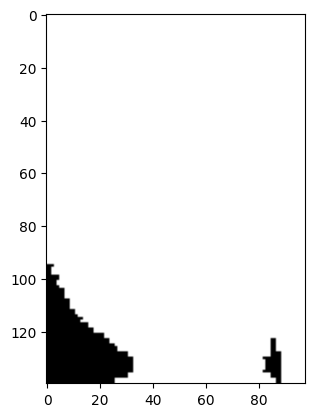

In [10]:
mask = load_mask("couple.jpg", 1)
print(mask.shape)
plt.imshow(tensor_to_image(mask))
plt.show()

In [17]:
FOLDER_PATH = os.path.join(os.getcwd(), 'images/Test')
print(FOLDER_PATH)

def pipeline( model, device):
    
    torch.autograd.set_detect_anomaly(True)
    
    df = pd.DataFrame() # dataframe storing the dataset
    row = {} #the information/columns for a single row in the dataset is stored here
    
    # Loop over all examples in test set
    for path in glob.glob(os.path.join(FOLDER_PATH, 'couple.jpg')):
        row['path'] = path
        print(path)
        
        # read and transform the image from the path
        data = cv2.imread(path)  # read the image
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
        data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
    
        data = data.to(device)
        
        print('Input')
        print(data.shape)
        plt.imshow(tensor_to_image(data))
        plt.show()
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Forward pass the data through the model
        output = model(data)
#         print('Model Output')
#         print(output)
#         print(output.shape)
        
        # call non max suppression
        nms, nms_output = non_max_suppression(output, 0.5, 0.5) #conf_thres and iou_thres = 0.5
        print('NMS')
        print(nms)
        print(nms_output)
        
        # loop through each of the faces in the image
        for face_index, face_row in enumerate(nms_output[0]): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
            row['face_index'] = face_index
            print('Face ', face_index)
            print(face_row)

            # Calculate the loss
            #TODO: check if this is correct when determining what should be the ground truth
            #Reference (https://github.com/xuexingyu24/YOLO-V3-in-Pytorch-A-Tutorial-on-Implementation-of-YOLO-V3-Algorithm/blob/master/Yolo_V3_Train_Step_by_Step.ipynb)
            x_loss = F.mse_loss(face_row[0], face_row[0])
            y_loss = F.mse_loss(face_row[1], face_row[1])
            w_loss = F.mse_loss(face_row[2], face_row[2])
            h_loss = F.mse_loss(face_row[3], face_row[3])
            obj_loss = F.binary_cross_entropy(face_row[4], torch.tensor(0.))
            cls_loss = F.binary_cross_entropy(face_row[5:], torch.tensor([0.])) # index 0 - face, index 1 - back. only the classification loss was used
            
            loss = x_loss + y_loss + w_loss + h_loss + obj_loss + cls_loss
            
            # get the coordinate of the face bounding box
            #(x1, y1) lower left, (x2, y2) upper right
            x1 = int(np.floor((face_row[0] - face_row[2] / 2).detach().cpu().numpy()))
            y1 = int(np.floor((face_row[1] - face_row[3] / 2).detach().cpu().numpy()))
            x2 = int(np.ceil((face_row[0] + face_row[2] / 2).detach().cpu().numpy()))
            y2 = int(np.ceil((face_row[1] + face_row[3] / 2).detach().cpu().numpy()))
            
            row['x1'], row['y1'], row['x2'], row['y2'] = x1, y1, x2, y2
            
            print('Cropped')
            print(x1, y1, x2, y2)
            cropped_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            cropped_image = tensor_to_image(cropped_image) #reshape the image to (w/h, h/w, channel)
            plt.imshow(cropped_image)
            plt.show()
            
            #TODO: Jay - extract image attributes here
            # extract the image attributes from  the 'cropped_image' variable
            # save the attributes as row['<column name in the dataset>'] = <data> (see examples above for reference)
            
            #extract_image_attributes(cropped_image)
            #extract_image_attributes(path, face_index, cropped_image)
            
            print('Resized')
            cropped_resized_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((cropped_image, np.zeros((1, 5))))[0], (1, 2, 0))
            plt.imshow(cropped_resized_image)
            plt.show()
            
            #TODO: Aaron - perform face segmentation here
            # using the 'cropped_resized_image'
            
            # Zero all existing gradients
            model.zero_grad()
            data.grad = None

            # Calculate gradients of model in backward pass
            loss.backward(retain_graph=True) #TODO: Amos - check if this is correct
            
            # Collect datagrad
            data_grad = data.grad.data
            print('Gradient')
            print(data_grad.shape)
            plt.imshow(np.transpose(np.clip(data_grad.squeeze(0).numpy(), 0, 1), (1, 2, 0)))
            plt.show()
            
            mask = load_mask(os.path.basename(path), face_index)
            inverted_mask = 1 - mask
            bbox = (x1, y1, x2, y2)
            
            print("bbox dim:", bbox)
            print(mask.shape, data[:, :, y1:y2, x1:x2].shape)
            
            # TODO - Amos - determine the value of epsilon by calling fgsm_attack and changing the value of epsilon (see code below)
            # the value of data(image) and data_grad remains constant diba
            print("Calculating min epsilon for YuNet...")
            yn_min_e = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yn_det_fn, mask, bbox)
            print("Calculating min epsilon for MediaPipe...")
            mp_min_e = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.mp_det_fn, mask, bbox)
            print("Calculating min epsilon for YoloFace...")
            yf_min_e = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, mask, bbox)
            print("yunet min:", yn_min_e, "mediapipe min:", mp_min_e, "yoloface min:", yf_min_e)
            # Call FGSM Attack
            perturbed_data = minE.fgsm_attack(data.clone().detach(), yf_min_e, data_grad.clone().detach(), mask, *bbox)
#             perturbed_data = fgsm_attack(data, max(yn_min_e, mp_min_e), data_grad) #data is the input image, epsilon
#             print("can detect faces on unperturbed img?", minE.mp_det_fn(data.detach()))
#             print(f"can detect faces on perturbed data with e={max(yn_min_e, mp_min_e) - 0.01}?", minE.mp_det_fn(fgsm_attack(data, max(yn_min_e, mp_min_e) - 0.01, data_grad).detach()))
#             print(f"can detect faces on perturbed img? with e={max(yn_min_e, mp_min_e) - 0.01}", minE.mp_det_fn(perturbed_data.detach()))
            
            df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe
            
            print('Perturbed')
            plt.imshow(tensor_to_image(perturbed_data))
            plt.show()
            
    df.to_csv(os.path.join(FOLDER_PATH, 'dataset' + str(int(time.time())) + '.csv'), index=False)  #save to csv

D:\Users\amosc\Documents\Coding\Thesis\THS-ST2\THS-ST1\images/Test


D:\Users\amosc\Documents\Coding\Thesis\THS-ST2\THS-ST1\images/Test\couple.jpg
Input
torch.Size([1, 3, 416, 416])


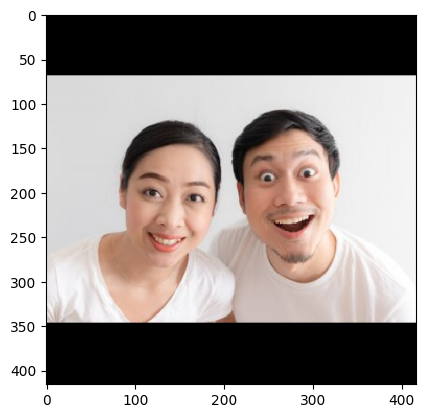

NMS
[tensor([[ 91.2910, 158.2145, 187.4069, 275.0190,   0.9991,   0.0000],
        [224.9028, 137.9499, 321.3420, 276.4984,   0.9975,   0.0000]])]
[tensor([[139.3489, 216.6168,  96.1159, 116.8046,   0.9997,   0.9994],
        [273.1224, 207.2242,  96.4393, 138.5485,   0.9981,   0.9994]],
       grad_fn=<IndexBackward0>)]
Face  0
tensor([139.3489, 216.6168,  96.1159, 116.8046,   0.9997,   0.9994],
       grad_fn=<UnbindBackward0>)
Cropped
91 158 188 276


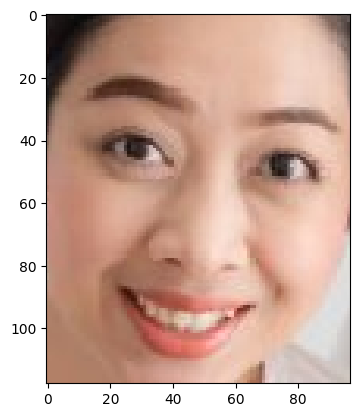

Resized


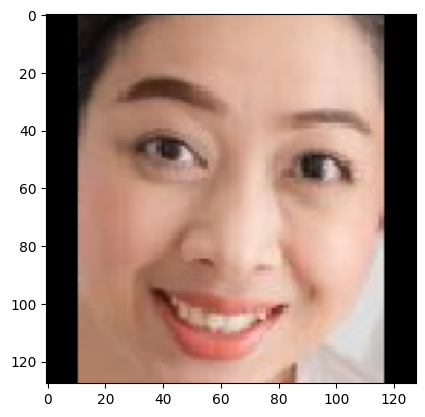

Gradient
torch.Size([1, 3, 416, 416])


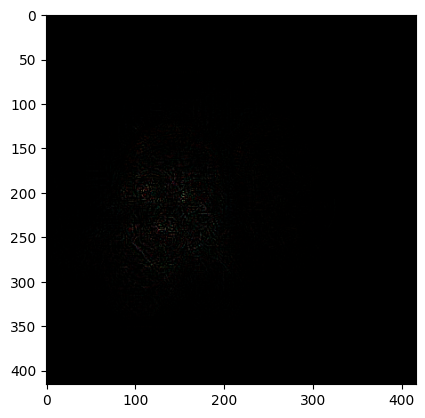

mask size before: (235, 235, 3)
target shape: (193, 235)
yoloshape: 97 118
21.0 0.0
mask size after: torch.Size([1, 3, 235, 193])
unpadded bbox: (0    91
Name: x1, dtype: int64, 0    158
Name: y1, dtype: int64, 0    188
Name: x2, dtype: int64, 0    276
Name: y2, dtype: int64)
padding: (48, 59, 48, 58)
bbox dim: (91, 158, 188, 276)
torch.Size([1, 3, 118, 97]) torch.Size([1, 3, 118, 97])
Calculating min epsilon for YuNet...
Calculating min epsilon for MediaPipe...
	before perturbation | closest bbox: ((78, 173, 193, 288), 0.6828353209165215) eps: 0.0
	e undetectable | closest bbox: ((215, 155, 331, 270), 0.0) eps: 0.65
True
	max e detectable | closest bbox: ((95, 162, 194, 261), 0.7665959876039797) eps: 0.6
Calculating min epsilon for YoloFace...
yunet min: 0 mediapipe min: 0.61 yoloface min: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_6040\1578768705.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


Perturbed


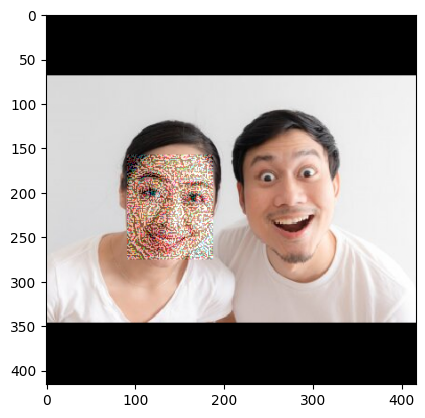

Face  1
tensor([273.1224, 207.2242,  96.4393, 138.5485,   0.9981,   0.9994],
       grad_fn=<UnbindBackward0>)
Cropped
224 137 322 277


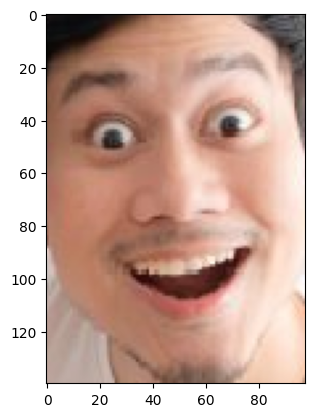

Resized


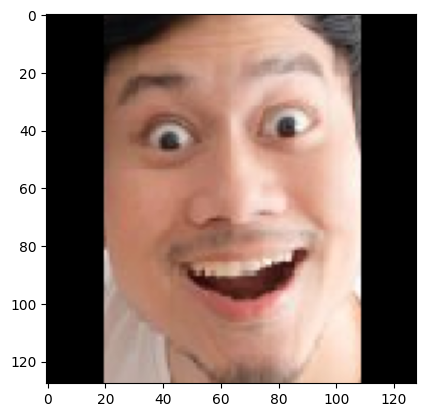

Gradient
torch.Size([1, 3, 416, 416])


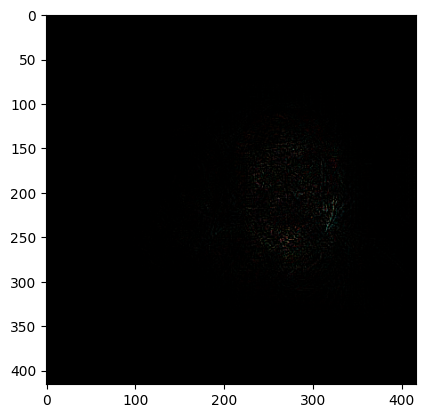

mask size before: (278, 278, 3)
target shape: (194, 278)
yoloshape: 98 140
42.0 0.0
mask size after: torch.Size([1, 3, 278, 194])
unpadded bbox: (1    224
Name: x1, dtype: int64, 1    137
Name: y1, dtype: int64, 1    322
Name: x2, dtype: int64, 1    277
Name: y2, dtype: int64)
padding: (48, 69, 48, 69)
bbox dim: (224, 137, 322, 277)
torch.Size([1, 3, 140, 98]) torch.Size([1, 3, 140, 98])
Calculating min epsilon for YuNet...
Calculating min epsilon for MediaPipe...
	before perturbation | closest bbox: ((215, 155, 331, 271), 0.7210084033613445) eps: 0.0
	e undetectable | closest bbox: ((78, 173, 194, 289), 0.0) eps: 0.44999999999999996
True
	max e detectable | closest bbox: ((228, 155, 318, 245), 0.593237337918189) eps: 0.41999999999999993
Calculating min epsilon for YoloFace...
yunet min: 0 mediapipe min: 0.42999999999999994 yoloface min: 0
Perturbed


C:\Users\amosc\AppData\Local\Temp\ipykernel_6040\1578768705.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


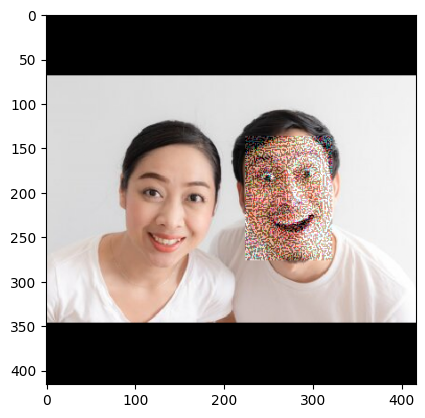

In [18]:
pipeline(model, device)

___